# Lightkurve periodogram & power-spectrum notebook (Coarse → Refined BLS)

This notebook is a revised version that implements a two-step Box‑Least‑Squares (BLS) search:
1) a fast coarse grid to find candidate peaks, then
2) a refined, high-resolution search around the strongest candidates.

It uses your CSV `tic437011608flattened-2min.csv` by default and the `Flattened Flux` column.

Generated: 2025-09-11 17:29 UTC

---



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle, BoxLeastSquares
try:
    import lightkurve as lk
except Exception as e:
    print('lightkurve not available; some convenience plotting may be skipped.', e)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,4)


In [6]:
# === EDIT THIS PATH IF YOUR FILE IS LOCATED ELSEWHERE ===
DATA_PATH = "../data/tic437011608flattened-2min.csv"

df = pd.read_csv(DATA_PATH)
print('Columns found:', df.columns.tolist())
display(df.head())

# Detect columns
time_col_candidates = [c for c in df.columns if 'time' in c.lower() or 'bjd' in c.lower()]
if any('flatten' in c.lower() for c in df.columns):
    flux_col_candidates = [c for c in df.columns if 'flatten' in c.lower()]
else:
    flux_col_candidates = [c for c in df.columns if 'flux' in c.lower()]

time_col = time_col_candidates[0] if time_col_candidates else df.columns[0]
flux_col = flux_col_candidates[0] if flux_col_candidates else df.columns[1]

time_rel = df[time_col].values.astype(float)
time_bjd = time_rel + 2457000.0
flux = df[flux_col].values.astype(float)

print(f"Using time column: '{time_col}' (interpreted as BJD-2457000).")
print(f"Using flux column: '{flux_col}'. Number of points: {len(time_rel)}") 


Columns found: ['Time (BJD-2457000)', ' Flux', ' Flattened Flux']


,Time (BJD-2457000),Flux,Flattened Flux
0,2500.195650,1.001089,1.000679
1,2500.197039,0.999310,0.998884
2,2500.198428,1.000477,1.000036
3,2500.199817,1.000212,0.999755
4,2500.201206,0.999567,0.999095


Using time column: 'Time (BJD-2457000)' (interpreted as BJD-2457000).
Using flux column: ' Flattened Flux'. Number of points: 32114


In [7]:
# Create a LightKurve LightCurve object (optional)
try:
    lc = lk.LightCurve(time=time_rel, flux=flux)
    print('LightKurve object created.')
except Exception as e:
    print('Lightkurve not available or failed to create LightCurve object:', e)
    lc = None


LightKurve object created.


Data points: 32114
Coarse periods: 1000 Refined resolution: 5000
Running coarse autopower... (this is reasonably fast)


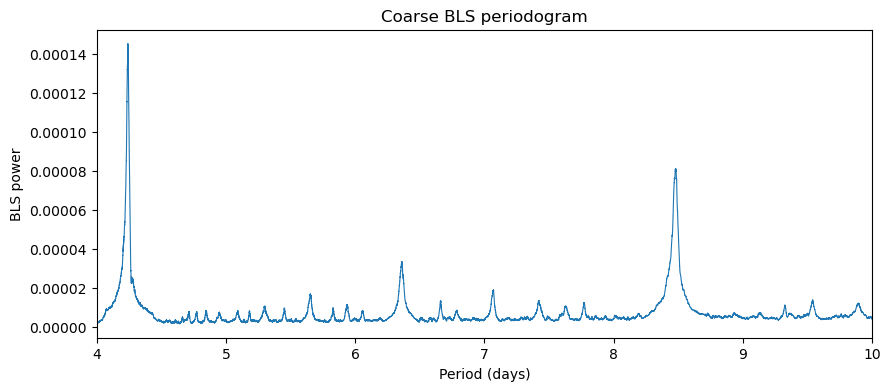

Candidate periods from coarse search (days): [4.239481891594861, 4.240577443750282, 4.239269914622811]


In [8]:
# ===== Two-step BLS: coarse -> refined =====
# PARAMETERS (tweakable)
min_period = 4.0      # days
max_period = 10.0     # days

# Coarse grid (fast)
n_coarse = 1000       # fewer trial periods to run quickly
durations = np.linspace(0.005, 2.0, 30)   # grid of durations (days) for autopower scan

# Refined grid (local around top peaks)
n_refined = 5000      # resolution for refined search (only around candidate peaks)
refine_width = 0.02   # fractional window around coarse peak to refine (e.g. 0.02 = +-2%)

print('Data points:', len(time_rel))
print('Coarse periods:', n_coarse, 'Refined resolution:', n_refined)

# --- Coarse BLS using astropy BoxLeastSquares.autopower ---
periods_coarse = np.linspace(min_period, max_period, n_coarse)
bls = BoxLeastSquares(time_rel, flux)
print('Running coarse autopower... (this is reasonably fast)')
try:
    # autopower accepts durations and returns arrays of period, power, duration...
    coarse_result = bls.autopower(durations, minimum_period=min_period, maximum_period=max_period)
    # Depending on astropy version, coarse_result may be a table-like with .period and .power
    period_c = coarse_result.period
    power_c = coarse_result.power
    plt.figure(); plt.plot(period_c, power_c, lw=0.8)
    plt.xlabel('Period (days)'); plt.ylabel('BLS power')
    plt.title('Coarse BLS periodogram'); plt.xlim(min_period, max_period)
    plt.show()
    # pick top candidate periods (local maxima)
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(power_c, height=np.nanmedian(power_c) + 3*np.nanstd(power_c))
    if len(peaks) == 0:
        # fallback: choose the global maximum
        best_idx_coarse = np.nanargmax(power_c)
        candidate_periods = [period_c[best_idx_coarse]]
    else:
        # sort peaks by power and take top 3 candidates
        peak_powers = power_c[peaks]
        order = np.argsort(peak_powers)[::-1]
        candidate_periods = list(period_c[peaks][order][:3])
    print('Candidate periods from coarse search (days):', candidate_periods)
except Exception as e:
    print('Coarse BLS autopower failed:', e)
    period_c = periods_coarse
    power_c = np.zeros_like(period_c)
    candidate_periods = []

In [9]:
# Plot a sinusoidal Lomb-Scargle model at the chosen best period
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

# --- choose best period from available results (priority: astropy BLS -> lightkurve BLS -> LS) ---
best_period = None
if 'best_period_astropy' in globals() and best_period_astropy is not None:
    best_period = float(best_period_astropy)
elif 'best_period_lk' in globals() and best_period_lk is not None:
    try:
        best_period = float(best_period_lk.value)
    except Exception:
        best_period = float(best_period_lk)
elif 'best_period_ls' in globals():
    best_period = float(best_period_ls)

if best_period is None:
    raise RuntimeError("No best period found. Run the periodogram cells first (BLS or LS).")

# frequency for Lomb-Scargle
best_freq = 1.0 / best_period

# make a dense time grid spanning your observations (use same time units as your time axis)
tmin, tmax = time_rel.min(), time_rel.max()
tgrid = np.linspace(tmin, tmax, 10000)   # dense grid for a smooth curve

# fit sinusoid model at that single frequency using LombScargle
ls = LombScargle(time_rel, flux)
model = ls.model(tgrid, best_freq)   # returns best-fit sinusoid+offset at that frequency

# optionally get a "max power" value to annotate the plot (try various sources)
max_power = None
if 'best_power_astropy' in globals() and best_power_astropy is not None:
    max_power = best_power_astropy
elif 'bls_result' in globals() and hasattr(bls_result, 'power'):
    # if using astropy BoxLeastSquares.autopower
    try:
        max_power = float(np.nanmax(bls_result.power))
    except Exception:
        max_power = None

# --- plotting ---
plt.figure(figsize=(13,5))
plt.plot(time_rel, flux, '.', color='0.15', markersize=1, alpha=0.6)   # raw points (time is BJD-2457000)
plt.plot(tgrid, model, linestyle='--', linewidth=3, color='red', label='LS Model')  # sinusoidal model

plt.xlabel('Time - 2457000 [days]')
plt.ylabel('Normalized Flux')
title = f'Best P: {best_period:.5f} d'
if max_power is not None:
    title += f'    Max Power: {max_power:.2f}'
plt.title(title, fontsize=16)
plt.legend(frameon=True)
plt.xlim(tmin, tmax)
plt.tight_layout()
plt.show()


RuntimeError: No best period found. Run the periodogram cells first (BLS or LS).

In [ ]:
# --- Refined searches around each candidate ---
refined_results = []
for p0 in candidate_periods:
    pmin = p0*(1.0 - refine_width)
    pmax = p0*(1.0 + refine_width)
    print(f'Refining around {p0:.6f} d -> window [{pmin:.6f}, {pmax:.6f}]')
    periods_ref = np.linspace(pmin, pmax, n_refined)
    try:
        # autopower with a single period range: use a narrower durations grid around the coarse best duration
        refined_autopower = bls.autopower(durations, minimum_period=pmin, maximum_period=pmax, goal='snr')
        # refined_autopower may have .period and .power
        per_r = refined_autopower.period
        pow_r = refined_autopower.power
        # find best
        best_idx = np.nanargmax(pow_r)
        best_p = per_r[best_idx]
        best_pow = pow_r[best_idx]
        best_dur = refined_autopower.duration[best_idx] if hasattr(refined_autopower, 'duration') else np.nan
        refined_results.append({'start':pmin, 'stop':pmax, 'best_period':float(best_p),
                                'best_power':float(best_pow), 'best_duration':float(best_dur)})
        plt.figure(); plt.plot(per_r, pow_r, lw=0.8)
        plt.xlabel('Period (days)'); plt.ylabel('BLS power')
        plt.title(f'Refined BLS around {p0:.6f} d (best {best_p:.6f} d)')
        plt.show()
    except Exception as e:
        print('Refined autopower failed for window', pmin, pmax, e)

print('\nRefined results (summary):')
for r in refined_results:
    print(r)
    
# If lightkurve is available, also attempt a lightkurve BLS as a convenience check
if lc is not None:
    try:
        print('\nAttempting Lightkurve BLS convenience call (may differ slightly):')
        lk_pg = lc.to_periodogram(method='bls', minimum_period=min_period, maximum_period=max_period)
        display(lk_pg)  # if this supports display in your environment
        print('Lightkurve BLS best period:', lk_pg.period_at_max_power)
    except Exception as e:
        print('Lightkurve BLS convenience call failed:', e)


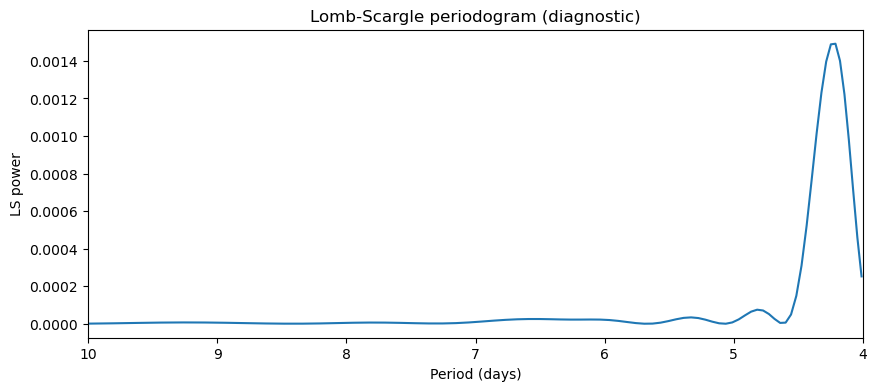

Lomb-Scargle best period (max power): 4.21334490004372


In [5]:
# Lomb-Scargle for diagnostics
min_freq = 1.0 / max_period
max_freq = 1.0 / min_period
ls = LombScargle(time_rel, flux)
freq, power = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=10)
periods_ls = 1.0 / freq
plt.figure(); plt.plot(periods_ls, power); plt.xlabel('Period (days)'); plt.ylabel('LS power'); plt.xlim(max_period, min_period)
plt.title('Lomb-Scargle periodogram (diagnostic)'); plt.show()
best_idx_ls = np.nanargmax(power)
best_period_ls = periods_ls[best_idx_ls]
print('Lomb-Scargle best period (max power):', best_period_ls)


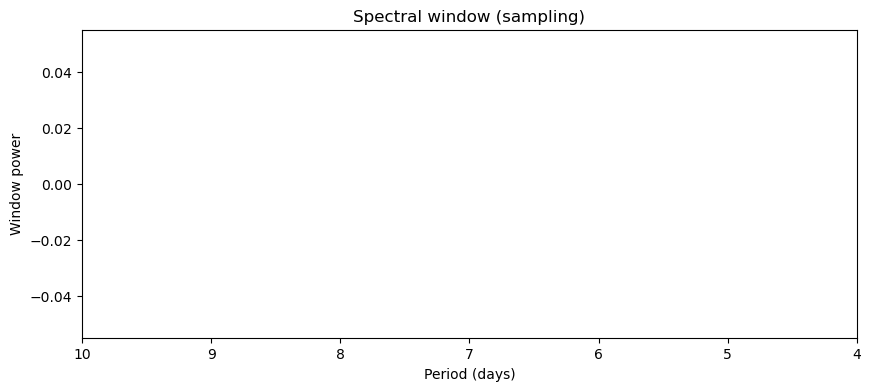

In [6]:
# Spectral window (sampling)
unit_signal = np.ones_like(time_rel)
ls_window = LombScargle(time_rel, unit_signal)
freq_w, power_w = ls_window.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=5)
period_w = 1.0 / freq_w
plt.figure(); plt.plot(period_w, power_w); plt.xlim(max_period, min_period)
plt.xlabel('Period (days)'); plt.ylabel('Window power'); plt.title('Spectral window (sampling)'); plt.show()


Best period chosen for folding: 4.21334490004372


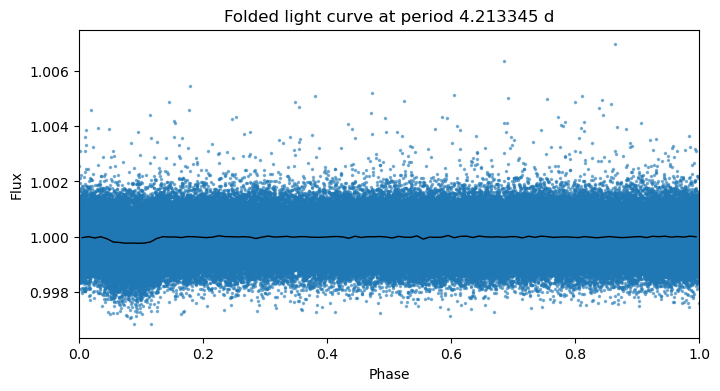

In [7]:
# Folding at the best refined period (if found), otherwise try LS or lightkurve result
best_period = None
if 'refined_results' in globals() and len(refined_results) > 0:
    best_period = refined_results[0]['best_period']
elif ('lk_pg' in globals()) and (lk_pg is not None):
    try:
        best_period = float(lk_pg.period_at_max_power)
    except:
        best_period = None
elif 'best_period_ls' in globals():
    best_period = best_period_ls

print('Best period chosen for folding:', best_period)
if best_period is not None:
    phase = ((time_rel % best_period) / best_period)
    phase = (phase + 0.5) % 1.0
    order = np.argsort(phase)
    p_sorted = phase[order]; f_sorted = flux[order]
    plt.figure(figsize=(8,4)); plt.plot(p_sorted, f_sorted, '.', markersize=3, alpha=0.5)
    from scipy import stats
    bins = 100
    bin_means, bin_edges, binnumber = stats.binned_statistic(p_sorted, f_sorted, statistic='median', bins=bins)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, '-k', lw=1)
    plt.xlabel('Phase'); plt.ylabel('Flux'); plt.title(f'Folded light curve at period {best_period:.6f} d')
    plt.xlim(0,1); plt.show()
else:
    print('No best period determined yet. Run the periodogram cells first.')


In [8]:
# Save refined results to JSON
import json
out = {}
out['refined_results'] = refined_results if 'refined_results' in globals() else []
if 'best_period_ls' in globals():
    out['best_period_ls'] = float(best_period_ls)
with open('periodogram_refined_results.json', 'w') as f:
    json.dump(out, f, indent=2)
print('Saved periodogram_refined_results.json')

Saved periodogram_refined_results.json


---
## Notes
- The coarse search uses `n_coarse` periods across your full search range (fast).
- The refined search centers on up to the top 3 candidates and scans a small fractional window `refine_width` around each with high resolution `n_refined`.
- Adjust `n_coarse`, `n_refined`, and `refine_width` to trade speed vs precision.
- If `BoxLeastSquares.autopower` is not available or fails due to astropy version differences, consider upgrading astropy (`pip install -U astropy`).

---
Generated by ChatGPT (not executed here).